<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204277 entries, 0 to 204276
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ProfileID           204277 non-null  object 
 1   ApplicantYears      204277 non-null  int64  
 2   AnnualEarnings      204277 non-null  int64  
 3   RequestedSum        204277 non-null  int64  
 4   TrustMetric         204277 non-null  int64  
 5   WorkDuration        204277 non-null  int64  
 6   ActiveAccounts      204277 non-null  int64  
 7   OfferRate           204277 non-null  float64
 8   RepayPeriod         204277 non-null  int64  
 9   DebtFactor          204277 non-null  float64
 10  QualificationLevel  204277 non-null  object 
 11  WorkCategory        204277 non-null  object 
 12  RelationshipStatus  204277 non-null  object 
 13  OwnsProperty        204277 non-null  object 
 14  FamilyObligation    204277 non-null  object 
 15  FundUseCase         204277 non-nul

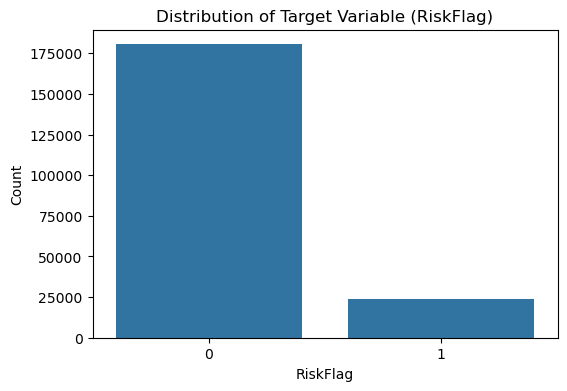

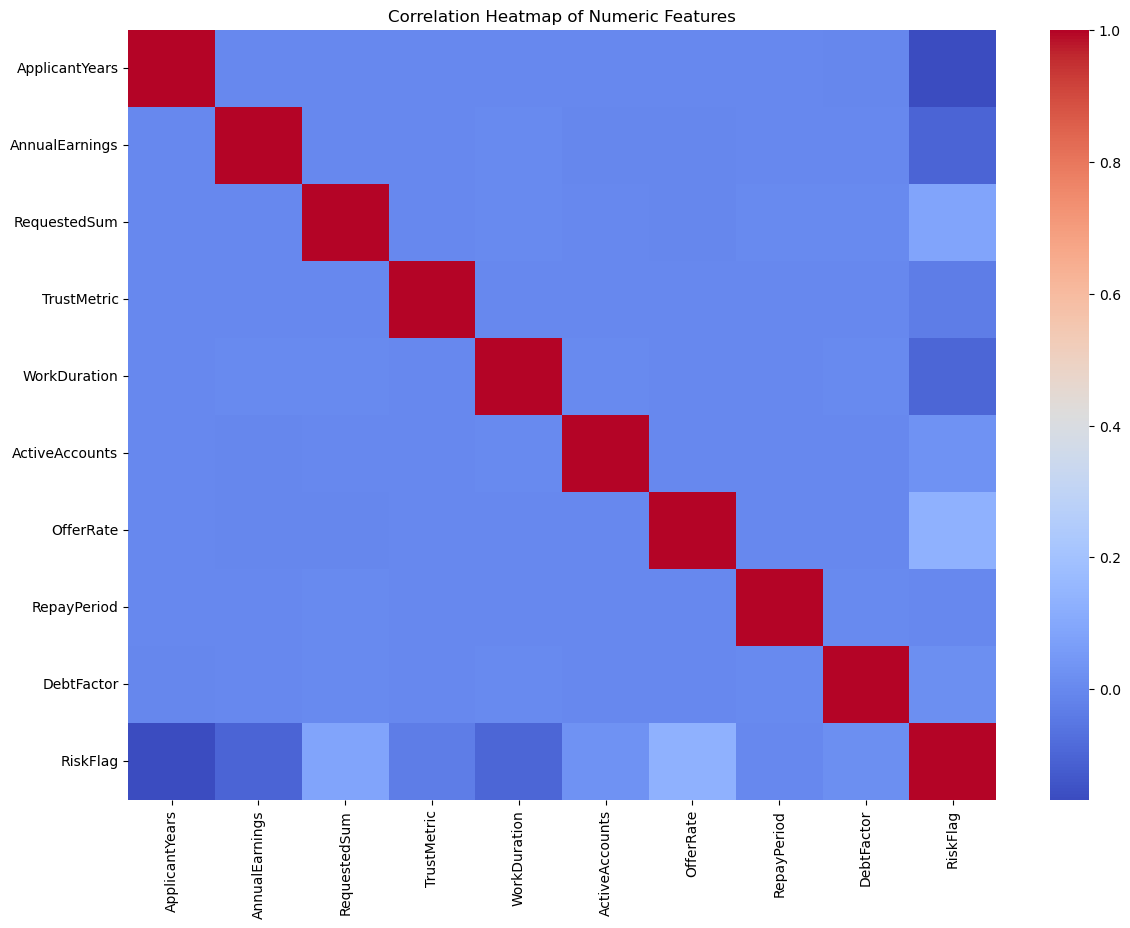

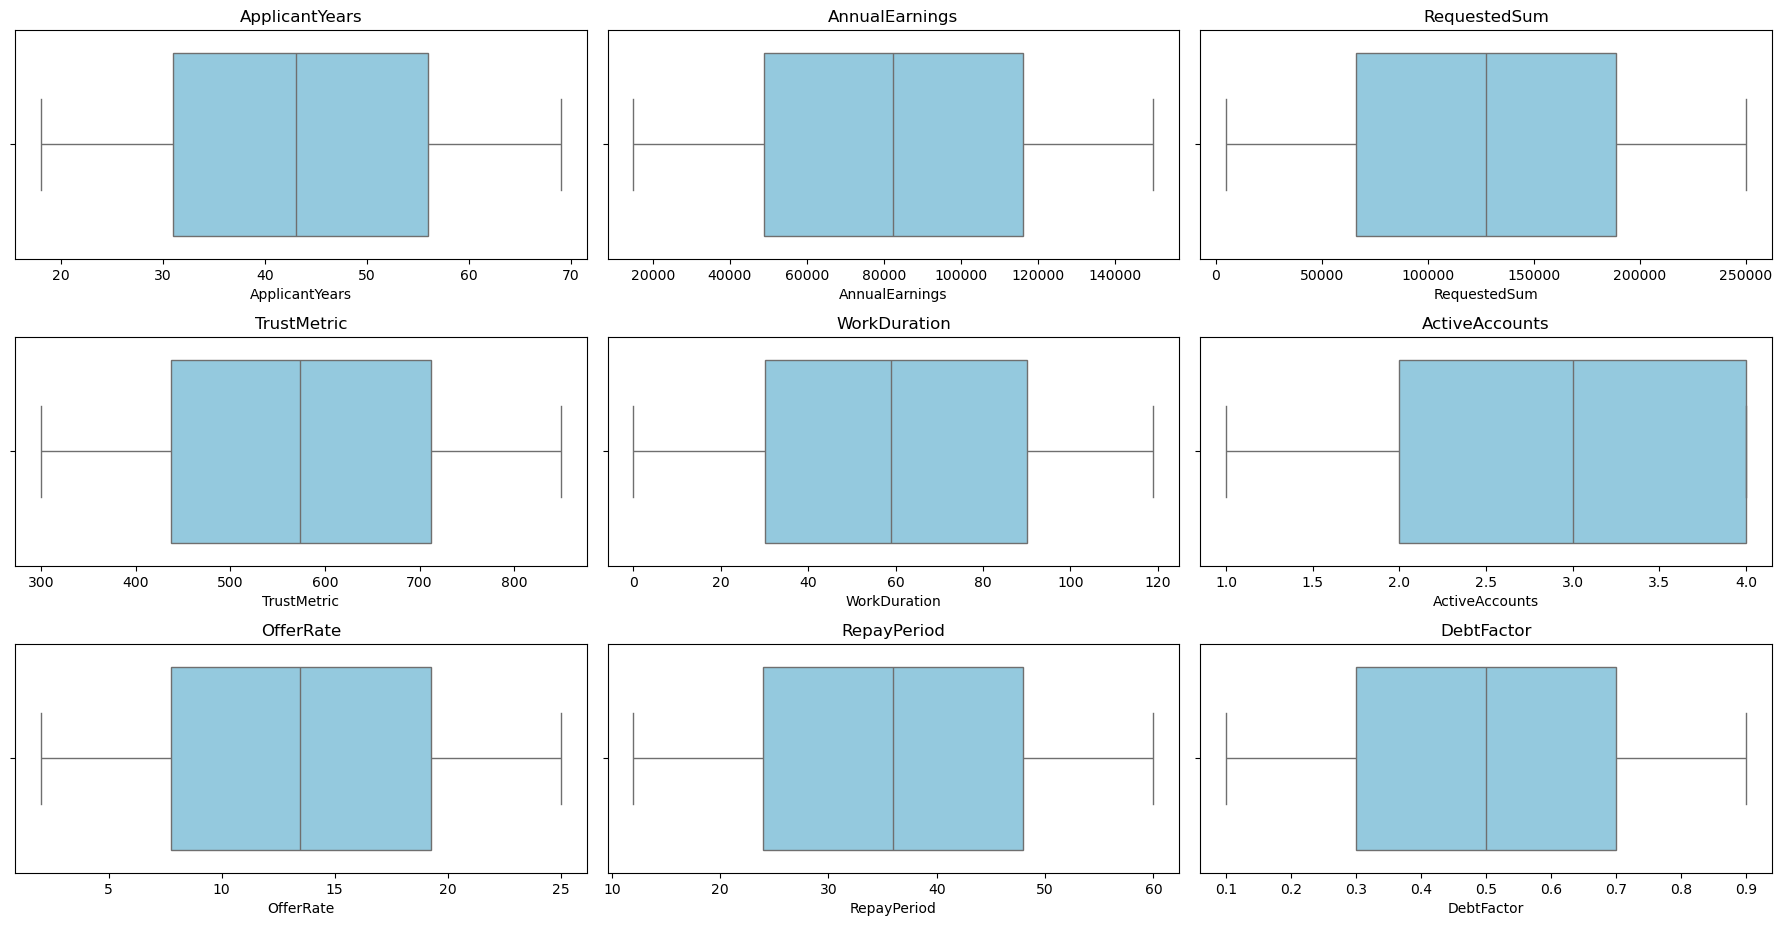

EDA Completed!
Top correlated features with RiskFlag:
Loan_to_Income           0.179606
ApplicantYears           0.167484
Repayment_to_Earnings    0.134303
EMI_to_Income            0.134303
Age_Group_2              0.130924
OfferRate                0.129885
AnnualEarnings           0.119026
MonthlyIncome            0.100515
WorkDuration             0.095429
Log_WorkDuration         0.089602
Name: RiskFlag, dtype: float64
Preprocessing Complete!
Train Shape: (204277, 39)
Test Shape: (51070, 39)


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

train_df = pd.read_csv('train_updated.csv')
test_df = pd.read_csv('test_updated.csv')

print(train_df.info())


# EDA
# Histogram
plt.figure(figsize=(6,4))
sns.countplot(x='RiskFlag', data=train_df)
plt.title("Distribution of Target Variable (RiskFlag)")
plt.xlabel("RiskFlag")
plt.ylabel("Count")
plt.show()

# Correlation Heatmap
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(14,10))
corr_matrix = train_df[numeric_cols].corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Boxplot
numeric_cols = train_df.select_dtypes(include=['int64','float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'RiskFlag']  

cols_to_plot = numeric_cols[:12]

plt.figure(figsize=(18,12))
for idx, col in enumerate(cols_to_plot, 1):
    plt.subplot(4, 3, idx)
    sns.boxplot(x=train_df[col], color='skyblue')
    plt.title(col)

plt.tight_layout()
plt.show()

print("EDA Completed!")



target = train_df['RiskFlag']
train_ids = train_df['ProfileID']
test_ids = test_df['ProfileID']

train_features = train_df.drop(columns=['RiskFlag', 'ProfileID'])
test_features = test_df.drop(columns=['ProfileID'])

combined_df = pd.concat([train_features, test_features], axis=0)

# Encoding 
education_map = {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}
combined_df['QualificationLevel'] = combined_df['QualificationLevel'].map(education_map)

binary_map = {'Yes': 1, 'No': 0}
for col in ['OwnsProperty', 'FamilyObligation', 'JointApplicant']:
    combined_df[col] = combined_df[col].map(binary_map)


# Feature Engineering

# Financial ratios
combined_df['Loan_to_Income'] = combined_df['RequestedSum'] / combined_df['AnnualEarnings']
combined_df['EMI_Approx'] = combined_df['RequestedSum'] / combined_df['RepayPeriod']
combined_df['EMI_to_Income'] = combined_df['EMI_Approx'] / (combined_df['AnnualEarnings'] / 12)
combined_df['Debt_to_Loan'] = combined_df['DebtFactor'] / (combined_df['RequestedSum'] + 1e-6)
combined_df['Earnings_per_Account'] = combined_df['AnnualEarnings'] / (combined_df['ActiveAccounts'] + 1e-6)
combined_df['MonthlyIncome'] = combined_df['AnnualEarnings'] / 12
combined_df['Repayment_to_Earnings'] = combined_df['RequestedSum'] / (combined_df['AnnualEarnings'] * combined_df['RepayPeriod'] / 12 + 1e-6)
combined_df['Margin_after_Debt'] = combined_df['MonthlyIncome'] - (combined_df['DebtFactor'] * combined_df['MonthlyIncome'])

# Interaction features
combined_df['Trust_Qualification'] = combined_df['TrustMetric'] * combined_df['QualificationLevel']
combined_df['WorkDuration_Qualification'] = combined_df['WorkDuration'] * combined_df['QualificationLevel']

# Temporal and count features
combined_df['Log_WorkDuration'] = np.log1p(combined_df['WorkDuration'])
combined_df['Log_ActiveAccounts'] = np.log1p(combined_df['ActiveAccounts'])
combined_df['WorkDuration_Bin'] = pd.cut(combined_df['WorkDuration'], bins=[-np.inf, 12, 60, np.inf], labels=[0,1,2])

# Age group bins: 18-30 young, 31-50 mid, 50+ senior
combined_df['Age_Group'] = pd.cut(combined_df['ApplicantYears'], bins=[0,30,50,np.inf], labels=[0,1,2])

# Property and JointApplicant interaction
combined_df['Property_JointApplicant'] = combined_df['OwnsProperty'] * combined_df['JointApplicant']

combined_df = pd.get_dummies(combined_df, columns=['WorkDuration_Bin', 'Age_Group'], drop_first=True)

for col in ['AnnualEarnings', 'RequestedSum']:
    combined_df[col] = np.log1p(combined_df[col])


combined_df = pd.get_dummies(combined_df, columns=['WorkCategory', 'RelationshipStatus', 'FundUseCase'], drop_first=True)

numeric_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
combined_df[numeric_cols] = scaler.fit_transform(combined_df[numeric_cols])

X = combined_df[:len(train_df)]
X_test_submission = combined_df[len(train_df):]
y = target

df_with_target = X.copy()
df_with_target['RiskFlag'] = y.values

correlations = df_with_target.corr()['RiskFlag'].drop('RiskFlag')

top_corr_features = correlations.abs().sort_values(ascending=False).head(10)

print("Top correlated features with RiskFlag:")
print(top_corr_features)


print("Preprocessing Complete!")
print(f"Train Shape: {X.shape}")
print(f"Test Shape: {X_test_submission.shape}")